Creating articifial dataset from MTGSetB (Multi-Touch dataset B) for ER of Untrimmed gestures task.


In [1]:
import os
import random
from typing import List, Tuple
from utils.parsing import simple_structure_parsing
from matplotlib import pyplot as plt
import copy

# pathOutputDataset = "C:\\workspace2\\Datasets\\2D\\MTG\\MTGSetB\\UntrimmedBrutData\\"
pathInputData = "C:\\workspace2\\Datasets\\2D\\MTG\MTGSetB\data\\"
pathOutputData = "C:\\workspace2\\Datasets\\2D\\MTG\MTGSetB_Untrimmed\data_AugmentedVersion\\"
separator = "\\"
pathAction = "C:\\workspace2\\Datasets\\2D\\MTG\MTGSetB\\"
actionFileName = "Actions.csv"
if not os.path.exists(pathOutputData):
    os.mkdir(pathOutputData)
    os.mkdir(pathOutputData+"Test")
    os.mkdir(pathOutputData+"Valid")
    os.mkdir(pathOutputData+"Train")


In [2]:
f = open(pathAction+actionFileName)
actions  =  f.readlines()
f.close()
actions = list(map(lambda s: s.split(";")[1].strip(),actions))

In [3]:
f = open("config.txt")
configParams = f.readlines()
f.close()
configParams = eval("\n".join(configParams))

In [4]:
multiplierCoord = configParams["multiplierCoord"]

def readFileAndAddData(file:str, gestures: List[Tuple[List[List[Tuple[float,float,float,float]]],str]],multiplierCoord):
    """
    add the gestures of the 'file' in the 'gestures' list
    :param file: the file (.inkml) which contains gestures
    :param gestures: the list to fill with gestures
                    Gesture[             ( Strokes[Points:Tuple[x,y,pressure,time]]    ,className)
                    List    [          Tuple[List[List[Tuple[float,float,float,float]], name]
    :return: void
    """
    gesturesMultiStrokes: List[Tuple[List[List[Tuple[float,float,float,float]]],str]] = simple_structure_parsing(file,multiplierCoord,removeDuplicatedPoint=True)
    gesturesMultiStrokes = list(map(lambda sample : (sample[0],"A_02") if sample[1]=="A_01" else (sample[0],sample[1]),gesturesMultiStrokes))
    #gesture A01 and A02 is the same class
    gestures.extend(gesturesMultiStrokes)

gesturesTrain : List[Tuple[List[List[Tuple[float,float,float,float]]],str]] = []
gesturesTest : List[Tuple[List[List[Tuple[float,float,float,float]]],str]] = []
gesturesValid : List[Tuple[List[List[Tuple[float,float,float,float]]],str]] = []

listFilesTest = os.listdir(pathInputData+"Test")
listFilesTrain = os.listdir(pathInputData+"Train")
print("Testing set")
for fileSample in listFilesTest:
    print(fileSample)
    readFileAndAddData(pathInputData+"Test"+separator+fileSample,gesturesTest,multiplierCoord)

random.seed(10)
random.shuffle(listFilesTrain)
validPart = 0.15
nbForValid = int(validPart*len(listFilesTrain))

listFilesValid = listFilesTrain[:nbForValid]
listFilesTrain = listFilesTrain[nbForValid:]

print("Training set")
for fileSample in listFilesTrain:
    readFileAndAddData(pathInputData+"Train"+separator+fileSample,gesturesTrain,multiplierCoord)
    readFileAndAddData(pathInputData+"Train"+separator+fileSample,gesturesTrain,multiplierCoord+0.01)
    readFileAndAddData(pathInputData+"Train"+separator+fileSample,gesturesTrain,multiplierCoord-0.01)

print(len(gesturesTest))
print(len(gesturesTrain))


for fileSample in listFilesValid:
    readFileAndAddData(pathInputData+"Train"+separator+fileSample,gesturesValid,multiplierCoord)

Testing set
003.inkml
006.inkml
008.inkml
009.inkml
010.inkml
012.inkml
dell2201_32_002.inkml
dell2202_32_001.inkml
dell2202_32_002.inkml
hp11_32_002.inkml
lenono2701_32_002.inkml
lenono2702_32_001.inkml
lenono2702_32_002.inkml
lenovo2701_46_001.inkml
samsung11_32_002.inkml
samsung11_32_004.inkml
samsung46_32_001.inkml
samsung46_46_001.inkml
Training set
4019
9261


In [5]:
labelsTrain = [cl for _,cl in gesturesTrain]
labelsTest = [cl for _,cl in gesturesTest]

Text(0.5, 1.0, 'Histogram of the number of elems by class (train set)')

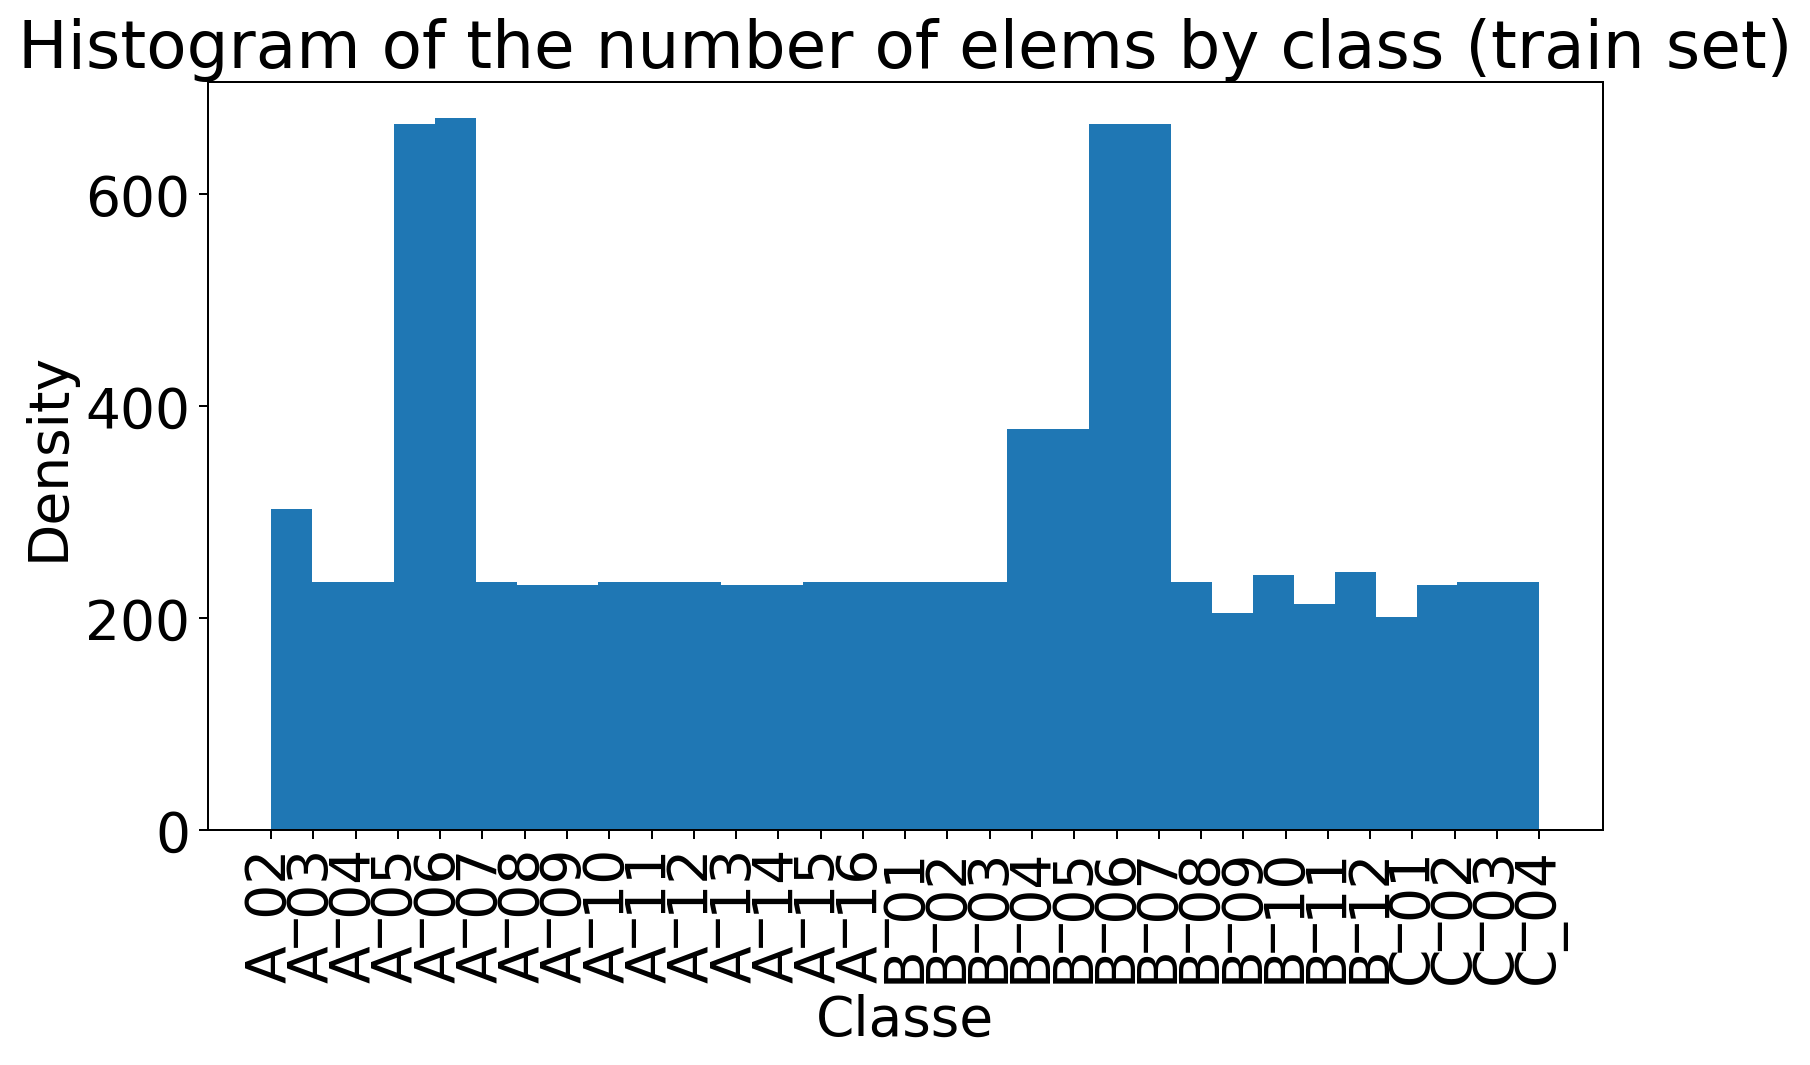

In [6]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,5.5),dpi=180)
plt.xticks(rotation=90)

density, bin, _ = plt.hist(labelsTrain,31)

plt.xlabel('Classe')
plt.ylabel('Density')
plt.title('Histogram of the number of elems by class (train set)')
# count = [len(gesture[0]) for gesture in gesturesSegmentsTest]

Text(0.5, 1.0, 'Histogram of the number of elems by class (test set)')

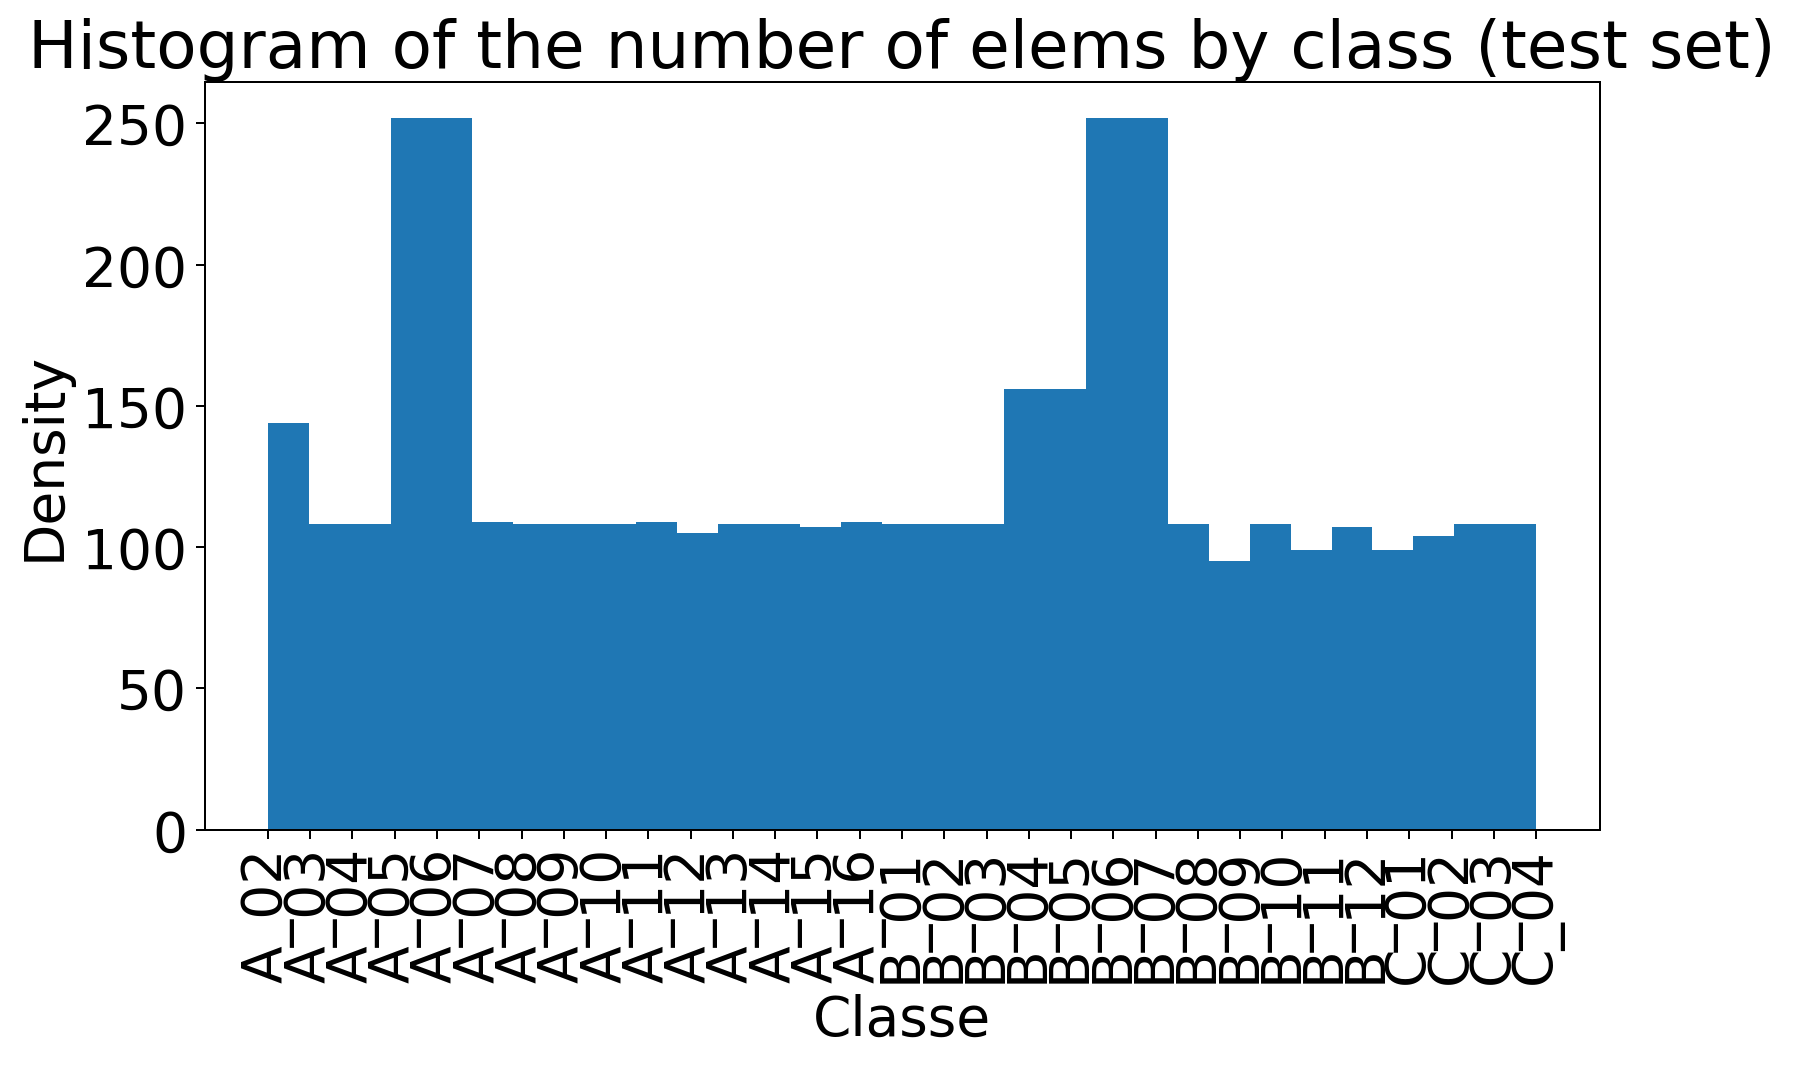

In [7]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,5.5),dpi=180)
plt.xticks(rotation=90)
_, _, _ = plt.hist(labelsTest,31)

plt.xlabel('Classe')
plt.ylabel('Density')
plt.title('Histogram of the number of elems by class (test set)')

In [8]:
def cumulateGesturesRandomly(gestures: List[Tuple[List[List[Tuple[float,float,float,float]]],str]],nbGesturePerSequence)->List[Tuple[List[List[Tuple[float,float,float,float]]],List[Tuple[str,int,int]]]]:
    """

    :param gestures: List[Tuple[List[List[Tuple[float,float,float,float]]],str]]
    """
    listeOfRemainingIndexes = list(range(0,len(gestures)))
    SequencesOfGestures : List[Tuple[List[List[Tuple[float,float,float,float]]],List[Tuple[str,int,int]]]] = []
    while len(listeOfRemainingIndexes)>0:
        lastPointCoord = (0,0)
        nbGesturePerSequenceToUse = random.randint(nbGesturePerSequence-2,nbGesturePerSequence+2)
        segments : List[List[Tuple[float,float,float,float]]] = []
        classNameStartEndStrokes:List[Tuple[str,int,int]] = []

        timeMax = 0
        i=0
        while i<nbGesturePerSequenceToUse and len(listeOfRemainingIndexes)>0:
            indexChosen =  random.randint(0,len(listeOfRemainingIndexes)-1)
            gestureIndex = listeOfRemainingIndexes[indexChosen]
            offset = gestures[gestureIndex][0][0][0][0]-lastPointCoord[0],\
                     gestures[gestureIndex][0][0][0][1]-lastPointCoord[1] #compute the offset to link two gestures

            listeOfRemainingIndexes.remove(gestureIndex)
            classNameStartEndStrokes += [(gestures[gestureIndex][1],len(segments),len(segments)+len(gestures[gestureIndex][0])-1)]
            gestSegmentsCopy = copy.deepcopy(gestures[gestureIndex][0])
            segments += gestSegmentsCopy

            timeMaxNextTime=0
            for seg in gestSegmentsCopy: # seg[0] : List[List[Tuple[float,float,float,float]]]
                for idd,p in enumerate(seg):
                    seg[idd] = (seg[idd][0]-offset[0],seg[idd][1]-offset[1],seg[idd][2],seg[idd][3]+timeMax)
                    lastPointCoord = seg[idd][0],seg[idd][1]

                time = seg[-1][3]
                timeMaxNextTime = time if time>timeMaxNextTime else timeMaxNextTime

            timeMax = timeMaxNextTime+15
            i+=1
        SequencesOfGestures.append((segments, classNameStartEndStrokes))
    return SequencesOfGestures

In [9]:
random.seed(5)

gesturesTest:List[Tuple[List[List[Tuple[float,float,float,float]]],List[Tuple[str,int,int]]]] = cumulateGesturesRandomly(gesturesTest,6)
gesturesValid:List[Tuple[List[List[Tuple[float,float,float,float]]],List[Tuple[str,int,int]]]] = cumulateGesturesRandomly(gesturesValid,6)

gestureTrainFinal:List[Tuple[List[List[Tuple[float,float,float,float]]],List[Tuple[str,int,int]]]] = []
gestureTrainFinal += cumulateGesturesRandomly(gesturesTrain,6)
gestureTrainFinal += cumulateGesturesRandomly(gesturesTrain,6)
print(len(gesturesTest))

672


## Export

In [10]:
gesture:Tuple[List[List[Tuple[float,float,float,float]]],List[Tuple[str,int,int]]]
def export(set,folder):
    for i,gesture in enumerate(set):
        strokes:List[List[Tuple[float,float,float,float]]] = gesture[0]
        labels:List[Tuple[str,int,int]] = gesture[1]

        stroke:List[Tuple[float,float,float]]
        chaine = ""
        for iStroke,stroke in enumerate(strokes):

            pointsSTR = []
            for point in stroke:
                x_y_z = " ".join(map(str,point))
                pointsSTR.append(x_y_z)

            chaine+= str(iStroke)+";"+"_".join(pointsSTR)+"\n"

        chaine += "#####Labels#####"+"\n"
        label:Tuple[str,int,int] #class,start,end
        for label in labels:
            classe_start_end = ",".join(map(str,label))
            chaine += classe_start_end + "\n"

        f = open(pathOutputData+folder+separator+"sequence"+str(i)+".ptc","w+")
        f.write(chaine)
        f.close()

In [11]:
export(gestureTrainFinal,"Train")
export(gesturesValid,"Valid")
export(gesturesTest,"Test")